# Refinement Trees and Parallelization with Space-Filling Curves

# Exercise 1: Hilbert-Order Encoding of a Quadtree

#### SFC python plotting routines:

In [1]:
import matplotlib.pyplot as plt


# functions to plot SFC
def plotLineStrip(x, y, title = None):
    _, ax = plt.subplots()
    plt.plot(x, y, linewidth = 2.0, color = 'g')
    if title is not None:
        plt.title(title)
    ax.set_xlim(min(x)-0.05, max(x)+0.05)
    ax.set_ylim(min(y)-0.05, max(y)+0.05)


def plotLineStripWithCells(x, y, cellx, celly, title = None):
    _, ax = plt.subplots()
    plt.plot(x, y, linewidth = 2.0, color = 'g')
    plt.plot(cellx, celly, linewidth = 1.0, color = 'b')
    if title is not None:
        plt.title(title)
    ax.set_xlim(min(cellx)-0.05, max(cellx)+0.05)
    ax.set_ylim(min(celly)-0.05, max(celly)+0.05)
    plt.gca().set_aspect('equal', adjustable='box')



#### Auxiliary routines to find the middle of an interval or a square

In [2]:
# helper functions to get the middle points of a segment or a cube
def mid2(a,b):
    """Rerurn the midpoint between two points,
    i.e. the center of the connecting edge."""

    return ((a[0]+b[0])/2.,(a[1]+b[1])/2.)

def mid4(a,b,c,d):
    """Return the center of a subsquare specified
    by its four corners."""
    return ((a[0]+b[0]+c[0]+d[0])/4.,(a[1]+b[1]+c[1]+d[1])/4.)

#### Quadtree examples encounded by a stream of numbers

The quadtree is represented via a variant of the bitstream encoding:
instead of 0/1 bits to represent whether a quadtree node is an inner
node or a leaf, we will apply an integer stream, where each number
represents the number of nodes contained in its respective subtree.
Hence, 1 represents a leaf node, and 5 would represent a quadtree
of height 2 with one inner node and four leaves. 

Implement get_task_tree() that return the quadtree build in Exercise 1 

In [3]:
# function to construct a uniformly refined tree of a given length
def gen_full_tree(depth):
    # depth: depth of the generated spacetree
    if depth == 0:
        spacetree = [1]
    else:
        ft = gen_full_tree(depth-1)
        f0 = [1+4*ft[0]]
        ft = ft*4
        spacetree = f0 + ft
    return spacetree

# "Fibonnacci-SpaceTree" (the depth decreases for the two last subtrees):
def gen_fib_tree(depth):
    # depth: depth of the generated spacetree
    if depth == 0:
        spacetree = [1]
    else:
        if depth == 1:
            dp = [depth-1]*4
        elif depth == 2:
            dp = [depth-1]*2 + [depth-2]*2
        else:
            dp = [depth-1] + [depth-2]*2 + [depth-3]
        fte = gen_fib_tree(dp[0])
        ft0 = fte[0]
        ft = fte
        for k in range(1,4):
            fte = gen_fib_tree(dp[k])
            ft0 += fte[0]
            ft += fte
        spacetree = [1+ft0]+ft

    return spacetree

# Return the tree from the worksheet Ex1
def get_task_tree():
    return [141,\
              45,\
                1,\
                13,\
                  1,\
                  1,\
                  5,  1,1,1,1,\
                  5,  1,1,1,1,\
                13,\
                  5,  1,1,1,1,\
                  1,\
                  5,  1,1,1,1,\
                  1,\
                17,\
                  5,  1,1,1,1,\
                  5,  1,1,1,1,\
                  1,\
                  5,  1,1,1,1,\
              61,\
                13,\
                  5,  1,1,1,1,\
                  1,\
                  1,\
                  5,  1,1,1,1,\
                17,\
                  5,  1,1,1,1,\
                  1,\
                  5,  1,1,1,1,\
                  5,  1,1,1,1,\
                17,\
                  5,  1,1,1,1,\
                  5,  1,1,1,1,\
                  1,\
                  5,  1,1,1,1,\
                13,\
                  5,  1,1,1,1,\
                  1,\
                  1,\
                  5,  1,1,1,1,\
              1,\
              33,\
                1,\
                17,\
                  5,  1,1,1,1,\
                  5,  1,1,1,1,\
                  1,\
                  5,  1,1,1,1,\
                13,\
                  5,  1,1,1,1,\
                  5,  1,1,1,1,\
                  1,\
                  1,\
                1]

#### Hilbert curve class to construct an adaptive space-filling curve

Method hilbertChilds is equivalent to method hilbertVL,
but generates an adaptive Hilbert order on the quadtree encoded
by the list vertices.

In [4]:
# Build the Hilbert curve to a spacetree
class HilbertSFCVertexLabAdp():

    def __init__(self):
        self.points = []
        self.unitsquare = [(0.,0.),(0.,1,),(1.,1.),(1.,0.)]
        self.spacetree = [1]
        self.stptr = -1
        self.cubes = []
        
        
    def mark(self, vertices):
        """Attach a point to the class lists of points
        (for plotting the respective connecting polygonial line)."""

        self.points.append(mid4(*vertices))
    
    def markCube(self, vertices):
        """Attach coordinates of a cube to class list of cubes."""

        self.cubes.extend(vertices+[vertices[0]]) #close the cube for plotting
        
    def getXY(self):
        """Split points into x and y list for convinient plotting."""

        x = [point[0] for point in self.points]
        y = [point[1] for point in self.points]

        return (x,y)

    def getCubeXY(self):
        """Split cube coordinates into x and y list for convinient plotting."""

        x = [cube[0] for cube in self.cubes]
        y = [cube[1] for cube in self.cubes]
        
        return (x,y)

    def hilbertChilds(self, vertices):
        self.stptr += 1
        if (self.spacetree[self.stptr] == 1):
            self.mark(vertices)
            self.markCube(vertices)
        else:
            mvall = mid4(*vertices)
            mv01 = mid2(vertices[0],vertices[1])
            mv03 = mid2(vertices[0],vertices[3])
            mv12 = mid2(vertices[1],vertices[2])
            mv23 = mid2(vertices[2],vertices[3])

            self.hilbertChilds([vertices[0], mv03, mvall, mv01])
            self.hilbertChilds([mv01, vertices[1], mv12, mvall])
            self.hilbertChilds([mvall, mv12, vertices[2], mv23])
            self.hilbertChilds([mv23, mvall, mv03, vertices[3]])
            
    def hilbert(self, spacetree):
        self.points = []
        self.cubes = []
        self.stptr = -1
        self.spacetree = spacetree
        self.hilbertChilds(self.unitsquare)

#### Demo

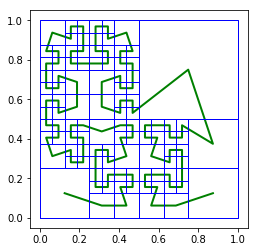

In [5]:
# Chose the spacetree

spacetree = get_task_tree()
#spacetree = gen_full_tree(4)
#spacetree = gen_fib_tree(5)


hsfc_adp = HilbertSFCVertexLabAdp()
hsfc_adp.hilbert(spacetree)
X, Y = hsfc_adp.getXY()
cellX, cellY = hsfc_adp.getCubeXY()
plotLineStripWithCells(X, Y, cellX, cellY)

# Exercise 2: Parallelization with Space-Filling Curves

#### Hilbert curve class to construct only a certain part of an adaptive space-filling curve

Override the method hilbertChilds to only mark the leafs between start and end using the leaf ordering from the traversal of the curve. You might need to add new class member field in the init or hilbert(...)

In [6]:
# Build a partial Hilbert curve to a spacetree
class HilbertSFCVertexLabAdpPart(HilbertSFCVertexLabAdp):

    def __init__(self):
        super().__init__()
        self.cellseen = 0
        
    def hilbertChilds(self, vertices):
        self.stptr += 1
        if (self.spacetree[self.stptr] == 1):
            self.cellseen += 1
            # leaf cell of the quadtree
            if ((self.cellseen >= self.first) and (self.cellseen <= self.last)):
                self.mark(vertices)
                self.markCube(vertices)
        else:
            # expand subtree, if member of the desired partition
            mvall = mid4(*vertices)
            mv01 = mid2(vertices[0],vertices[1])
            mv03 = mid2(vertices[0],vertices[3])
            mv12 = mid2(vertices[1],vertices[2])
            mv23 = mid2(vertices[2],vertices[3])

            self.hilbertChilds([vertices[0], mv03, mvall, mv01])
            self.hilbertChilds([mv01, vertices[1], mv12, mvall])
            self.hilbertChilds([mvall, mv12, vertices[2], mv23])
            self.hilbertChilds([mv23, mvall, mv03, vertices[3]])

    def hilbert(self,spacetree,first,last):
        self.points = []
        self.cubes = []
        self.stptr = -1 
        self.spacetree = spacetree
        self.cellseen = 0
        self.first = first
        self.last = last
        self.hilbertChilds(self.unitsquare)

#### Demo

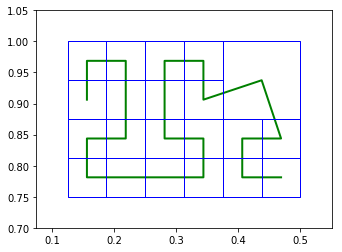

In [12]:
hsfc_adp_part = HilbertSFCVertexLabAdpPart()
hsfc_adp_part.hilbert(spacetree,50,70)
X, Y = hsfc_adp_part.getXY()
cellX, cellY = hsfc_adp_part.getCubeXY()
plotLineStripWithCells(X, Y, cellX, cellY)